**Assignment 3: Variational quantum algorithms**

In this assignment, we are going to explore the variational quantum eigensolver together.

We will start by looking at a concrete example together, and then you will write some extensions yourself. Remember, if anything here confuses you, make sure to consult the [IBM variational quantum algorithms course](https://learning.quantum.ibm.com/course/variational-algorithm-design).

Ok, lets go!

The first thing we do, is import the necessary packages.

In [69]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
from qiskit import *
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import SparsePauliOp
import numpy as np
from scipy.linalg import expm
import scipy.linalg as la
from scipy.optimize import minimize

from qiskit_aer.primitives import Estimator
estimator = Estimator(approximation=True)

The next thing we are going to do is create a **cost function**, which takes in:

 - the parameter values of our parameterized quantum circuit (our ansatz)
 - the ansatz circuit itself
 - the Hamiltonian whose ground state we would like to find.
 - A qiskit `estimator` object, which we use to calculate the expectation value of the Hamiltonian with respect to the parameterized state.

The cost function then outputs an estimate of the expectation value, which gets fed into the classical optimizer.

In [70]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

Given the cost function, the next thing we are going to do is use the generic function from assignment 2, for generating Hamiltonians of the 1d dimensional transverse field Ising model. For now, these are the Hamiltonians whose ground state energy we would like to find using the variational quantum eigensolver.

In [71]:
def get_1d_Ising_hamiltonian(N, J, h):
    
    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [('ZZ', [i, i + 1], -J) for i in range(0, N-1)]
    X_tuples = [('X', [i], -h) for i in range(0, N)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=N) #Note the clever list concatenation
    return hamiltonian.simplify()

Ok, we have the cost function, and we have a function for generating Hamiltonians. The next thing we need is to define the parameterized quantum circuit that we will use within the variational quantum algorithm.

Below is an example of a specific variational quantum circuit of two qubits which consists of:

 - A reference unitary which applies an $X$ gate to qubit 0
 - A variational unitary consisting of two rotation blocks, with an entangling block in the middle. Each rotation block consists of a layer of $R_Z$ rotations, followed by a later of $R_Y$ rotations.



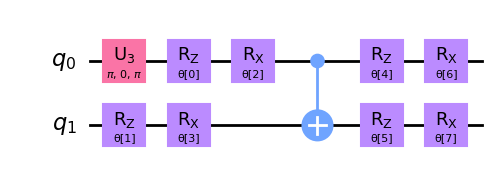

In [72]:
reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz","rx"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)
ansatz.decompose().draw('mpl')

Now we have all the ingredients to use the variational quantum eigensolver to find the ground state of a 2 qubit 1-dimensional transverse field ising model...

In [73]:
Hamiltonian = get_1d_Ising_hamiltonian(2,1,0)       # Fetch an instance of a 2-qubit Ising Hamiltonian

x0 = np.ones(8)                                      # initial values for the variational parameters

result = minimize(cost_func_vqe, x0, args=(ansatz, Hamiltonian, estimator), method="COBYLA")      # Run the VQE

In [74]:
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.9999999630626717
       x: [ 1.994e+00  1.108e+00  1.572e+00  3.677e-01  1.077e+00
            2.222e+00  2.950e-01  1.742e-01]
    nfev: 305
   maxcv: 0.0


----------------------
**Tasks**

For all the tasks below, write your answers in notebook blocks beneath the task description. If you have to write code, write code, and if you have to write explanations or text, use markdown with LaTex.


---------------------------
**Task 1**

We have used a very specific variational quantum circuit. Your first task is to write a function called `create_ansatz` which takes in hyper-parameters, and outputs a parameterized QuantumCircuit object which we will use as an ansatz. In particular, your function should take in the following parameters.

 - Number of qubits
 - A Boolean valued variable `reference`: If `reference` is $1$ then an initial layer of $X$ gates should be applied to each qubit. If `reference` is 0 then there should be no initial reference circuit.
 - A list called `rotations` which contains a subset of the strings $X$,$Y$ and $Z$. If string $A\in \{X,Y,Z\}$ is present in `rotations`, then each rotation layer should contain a layer of $A$ rotation gates. For example, if `rotations=["X","Z"]` then each rotation layer should consist of a layer of $X$ rotations and a layer of $Z$ rotations.
 - Define one circuit block as a rotation layer followed by an entangling layer. The function should take as input a non-negative integer `num_blocks` which determines how many circuit blocks there are. We will always end with a final rotation layer.

---------------------------
**Task 2**

Write a function called `run_vqe` which takes in:

 - A Hamiltonian
 - An ansatz circuit
 - a vector of initial parameters
 - A scipy minimizer method (for example `COBYLA`, `BFGS`, `SLSQP`)

and returns as output the converged approximation of the ground state energy, found using the desired optimizer

---------------------------
**Task 3**

Use the functions you have written, to do the following:

**3.1** Using an ansatz circuit consisting of no reference circuit, and two circuit blocks with only $X$ rotation layers, plot the output groundstate energy obtained via VQE with `COBYLA` of the 1-dimensional transverse field Ising model on 5 qubits, for $J\in [0,0.25,...,2]$ and $h\in [0,0.25,...,2]$. Do the same plot buy using the optimizer `BFGS`.

**3.2** Create the same plots as in question 3.1, but with an ansatz circuit consisting of no reference circuit, and only one circuit block with $X,Y$ and $Z$ rotations. So again, plot the output groundstate energy of the 1-dimensional transverse field Ising model on 5 qubits, for $J\in [0,0.25,...,2]$ and $h\in [0,0.25,...,2]$, using both optimizers.


---------------------------
**TASK 4**

Write a function called `get_2dimensional_Ising_Hamiltonian` which takes in values $L,J,H$ and outputs a sparse pauli operator for the 2-dimensional transverse field Ising model on a square $L$ by $L$ grid (i.e.with $L^2$ qubits) -- I.e. the Hamiltonian for a square $L$ by $L$ lattice where each qubit (in the bulk of the lattice) interacts with its four nearest neighbour qubits with a $ZZ$ interaction, and each qubit gets acted on via the transverse magnetic field $X$.

---------------------------
**TASK 5**

Write a pseudocode description, of how the Qiskit `Estimator` object estimates the expectation value of the Hamiltonian from computational basis measurements. In other words, sketch an algorithm one can use to estimate the expectation value of any observable if one can only do computational basis measurements. (Note, you can also add LaTex to the cells to help your explanation!)

---------------------------
**TASK 6**

In June this year IBM [published in Nature](https://www.nature.com/articles/s41586-023-06096-3) the results of an experiment on a 127 qubit quantum computer. (See also the attached paper entitled "Evidence for the utility of quantum computing before fault tolerance").

Write a summary of the paper in your own words which describes:

1. What scientific problem did the paper try to solve? Why is it important or interesting to scientists?
2. Which Hamiltonian did they study, and what system does it represent?
3. Why does it make sense to use a quantum algorithm for this problem?
4. Which quantum algorithm did they run?
5. What were the biggest challenges involved in running this algorithm?
6. What are the best classical competitors to the quantum algorithm?
7. What in your opinion were the biggest shortcomings of the experiment?
8. What in your opinion is the most exciting part of the experiment?
9. If you could work on one research problem to try improve this experiment, what would it be?